# Complete RAPA Tutorial
This tutorial is meant to cover multiple RAPA use cases, including starting from scratch or using a previous DataRobot project.

### Overview
1. Initialize the DataRobot API 
    - Save a pickled dictionary for DataRobot API Initialization
    - Use the pickled dictionary to initialize the DataRobot API
    - **(Optional)**: Skip this if the DataRobot API is previously initialized
2. Submit data as a project to DataRobot
    - Create a submittable `pandas` dataframe
    - Submit the data using RAPA
    - **(Optional)**: If parsimonious feature reduction is required on an existing project, it is possible to load the project instead of creating a new one.
3. Perform parsimonious feature reduction

<a href="https://life-epigenetics-rapa.readthedocs-hosted.com/en/latest/">[Link to the documentation]</a>

## Import rapa

In [1]:
import rapa

In [2]:
print(rapa.__version__)

0.0.5


## 1. Initialize DataRobot the API

In [3]:
# import pickle
import pickle
import os

### On the <a href="app.datarobot.com"> DataRobot website </a>, find the developer tools and retrieve an API key. Once you have a key, make sure to run the next block of code with your api key replacing the value in the dictionary. Here is a <a href="https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html">detailed article on DataRobot API keys</a>.

### **Make sure to remove code creating the pickled dataframe and the pickled dataframe itself from any public documents, such as GitHub.**


In [4]:
# save a pickled dictionary for datarobot api initialization
api_dict = {'tutorial':'APIKEYHERE'}
if 'data' in os.listdir('.'):
    print('data folder already exists, skipping folder creation...')
else:
    print('Creating data folder in the current directory.')
    os.mkdir('data')

if 'dr-tokens.pkl' in os.listdir('data'):
    print('dr-tokens.pkl already exists.')
else:
    with open('data/dr-tokens.pkl', 'wb') as handle:
        pickle.dump(api_dict, handle)

data folder already exists, skipping folder creation...
dr-tokens.pkl already exists.


In [5]:
# Use the pickled dictionary to initialize the DataRobot API
rapa.utils.initialize_dr_api('tutorial')

DataRobot API initiated with endpoint 'https://app.datarobot.com/api/v2'


The majority of this tutorial uses the DataRobot API, so if the API is not initialized, it will not run.

## 2. Submit data as a project to DataRobot

This tutorial uses the Breast cancer wisconsin (diagnostic) dataset as an easily accessible example set for `rapa`, as it easily loaded with `sklearn`. 

This breast cancer dataset has **30 features** extracted from digitized images of aspirated breast mass cells. A few features are the mean radius of the cells, the mean texture, mean perimater  The **target** is whether the cells are from a malignant or benign tumor, with 1 indicating benign and 0 indicating malignant. There are 357 benign and 212 malignant samples, making 569 samples total.

In [6]:
from sklearn import datasets # data used in this tutorial
import pandas as pd # used for easy data management

In [7]:
# loads the dataset (as a dictionary)
breast_cancer_dataset = datasets.load_breast_cancer() 

In [8]:
# puts features and targets from the dataset into a dataframe
breast_cancer_df = pd.DataFrame(data=breast_cancer_dataset['data'], columns=breast_cancer_dataset['feature_names'])
breast_cancer_df['benign'] = breast_cancer_dataset['target']
print(breast_cancer_df.shape)
breast_cancer_df.head()

(569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,benign
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


When using `rapa` to create a project on DataRobot, the number of features is reduced using on of the sklearn functions `sklearn.feature_selection.f_classif`, or `sklearn.feature_selection.f_regress` depending on the `rapa` instance that is called. In this tutorial's case, the data is a binary classification problem, so we have to create an instance of the `rapa.RAPAClassif` class.

As of now, `rapa` only supports classification and regression problems on DataRobot. Additionally, `rapa` has only been tested on tabular data. 

In [9]:
# Creates a rapa classifcation object
depression_classification = rapa.rapa.RAPAClassif()

In [10]:
# creates a datarobot submittable dataframe with cross validation folds stratified for the target (benign)
sub_df = depression_classification.create_submittable_dataframe(breast_cancer_df, target_name='benign')
print(sub_df.shape)
sub_df.head()

(569, 32)


,benign,partition,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0,CV Fold 5,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,CV Fold 3,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,CV Fold 5,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,CV Fold 0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,CV Fold 5,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [11]:
# submits a project to datarobot using our dataframe, target, and project name.
project = depression_classification.submit_datarobot_project(input_data_df=sub_df, target_name='benign', project_name='TUTORIAL_breast_cancer')
project

Project(TUTORIAL_breast_cancer)

In [12]:
# if the project already exists, the `rapa.utils.find_project` function can be used to search for a project
project = rapa.utils.find_project("TUTORIAL_breast_cancer")
project

Project(TUTORIAL_breast_cancer)

## 3. Perform parsimonious feature reduction

`rapa`'s main function is `perform_parsimony`. Requiring a *feature_range* and a *project*, this function recursively removes features by their relative feature impact scores across all models in a featurelist, creating a new featurelist and set of models with DataRobot each iteration.

* **feature_range:** a list of desired featurelist lengths as integers (Ex: [25, 20, 15, 10, 5, 4, 3, 2, 1]), or of desired featurelist sizes (Ex: [0.9, 0.7, 0.5, 0.3, 0.1]). This tells `rapa` how many features remain after each iteration of feature reduction.
* **project:** either a `datarobot` project, or a string of it’s id or name. `rapa.utils.find_project` can be used to find a project already existing in DataRobot, or `submit_datarobot_project` can be used to submit a new project.
* **featurelist_prefix:** provides `datarobot` with a prefix that will be used for all the featurelists created by the `perform_parsimony` function. If running `rapa` multiple times in one DataRobot project, make sure to change the **featurelist_prefix** each time to avoid confusion.
* **starting_featurelist_name:** the name of the featurelist you would like to start parsimonious reduction from. It defaults to 'Informative Features', but can be changed to any featurelist name that exists within the project.
* **lives:** number of times allowed for reducing the featurelist and obtaining a worse model. By default, ‘lives’ are off, and the entire ‘feature_range’ will be ran, but if supplied a number >= 0, then that is the number of ‘lives’ there are. (Ex: lives = 0, feature_range = [100, 90, 80, 50] RAPA finds that after making all the models for the length 80 featurelist, the ‘best’ model was created with the length 90 featurelist, so it stops and doesn’t make a featurelist of length 50.) This is similar to DataRobot’s <a href="https://www.datarobot.com/blog/using-feature-importance-rank-ensembling-fire-for-advanced-feature-selection/">Feature Importance Rank Ensembling for advanced feature selection (FIRE)</a> package’s ‘lifes’.
* **cv_average_mean_error_limit**: limit of cross validation mean error to help avoid overfitting. By default, the limit is off, and the each ‘feature_range’ will be ran. Limit exists only if supplied a number >= 0.0.
* **to_graph**: a list of keys choosing which graphs to produce. Current graphs are *feature_performance* and *models*. *feature_performance* graphs a stackplot of feature impacts across many featurelists, showing the change in impact over different featurelist lengths. *models* plots `seaborn` boxplots of some metric of accuracy for each featurelist length. These plots are created after each iteration.

Additional arguments and their effects can be found <a href="https://life-epigenetics-rapa.readthedocs-hosted.com/en/latest/">in the API documentation</a>, or within the functions.

---------- Informative Features (30) ----------
Informative Features: Waiting for previous jobs to complete...
Previous job(s) remaining (0))
Informative Features: Waiting for feature impact...
Feature Impact job(s) remaining (0))
Feature Impact: (148.15s)
Graphing feature performance...


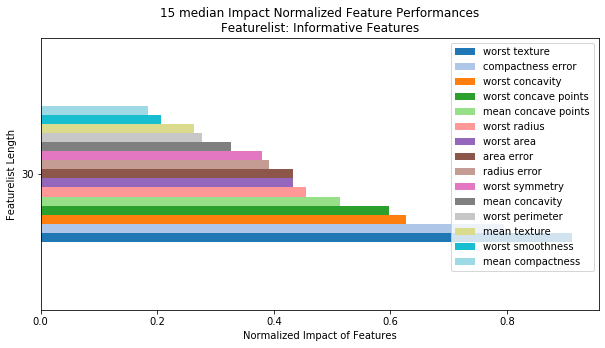

DataRobot job(s) remaining (0)
Project: TUTORIAL_breast_cancer | Featurelist Prefix: TEST_0.0 | Feature Range: [25, 20, 15, 10, 5, 4, 3, 2, 1]
Feature Importance Metric: median | Model Performance Metric: AUC
Lives: 5
CV Mean Error Limit: 0.8


  0%|          | 0/9 [00:00<?, ?it/s]

---------- TEST_0.0 (25) ----------
Autopilot: 535.20s
Feature Impact job(s) remaining (0)
Feature Impact: 140.13s
Waiting for DataRobot: 5.89s


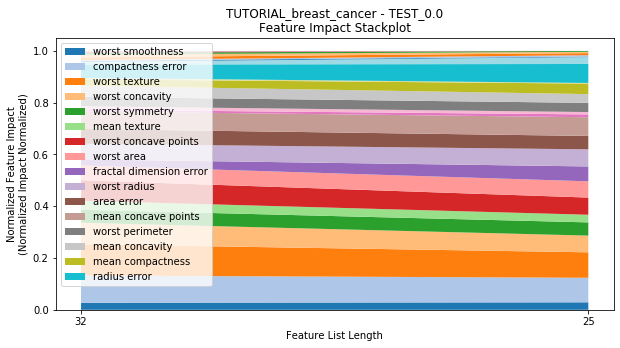

Performance Stackplot: 2.99s


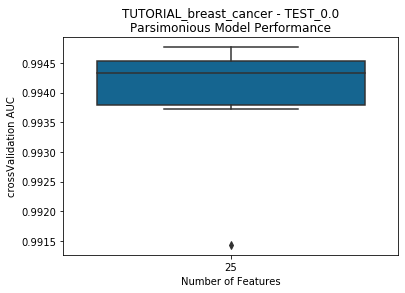

Model Performance Boxplot: 0.81s
Checking lives: 15.55s
Lives left: 5 | Previous Model Best Score: 0.994668 | Current Best Model Score: current_best_model_score=0.994762
Mean Error Limit: 3.48s
CV Error From the Mean: 0.009298857367689383 | CV Mean Error Limit: 0.8 | CV Model Performance Metric: AUC
---------- TEST_0.0 (20) ----------
Autopilot: 352.84s
Feature Impact job(s) remaining (0)
Feature Impact: 117.13s
Waiting for DataRobot: 6.57s


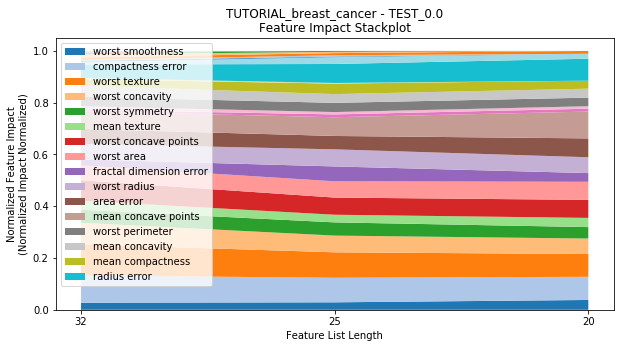

Performance Stackplot: 4.09s


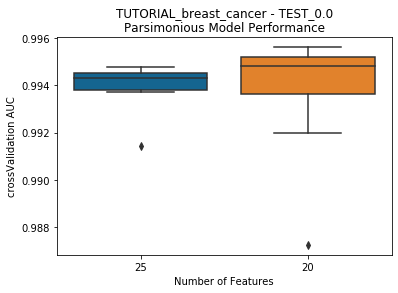

Model Performance Boxplot: 1.16s
Checking lives: 27.35s
Lives left: 5 | Previous Model Best Score: 0.994668 | Current Best Model Score: current_best_model_score=0.994762
Mean Error Limit: 3.68s
CV Error From the Mean: 0.009301180235749574 | CV Mean Error Limit: 0.8 | CV Model Performance Metric: AUC
---------- TEST_0.0 (15) ----------
Autopilot: 331.93s
Feature Impact job(s) remaining (0)
Feature Impact: 113.38s
Waiting for DataRobot: 5.90s


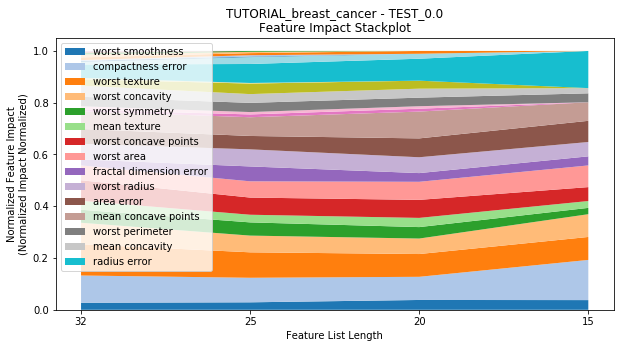

Performance Stackplot: 4.81s


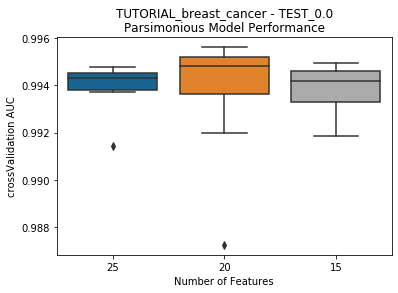

Model Performance Boxplot: 1.24s
Current model performance: '0.995618'. Previous best model performance: '0.995618'
No change in the best model, so a life was lost.
Lives remaining: '4'
Checking lives: 41.86s
Lives left: 4 | Previous Model Best Score: 0.994668 | Current Best Model Score: current_best_model_score=0.994762
Mean Error Limit: 3.06s
CV Error From the Mean: 0.008976675621498544 | CV Mean Error Limit: 0.8 | CV Model Performance Metric: AUC
---------- TEST_0.0 (10) ----------
Autopilot: 433.30s
Feature Impact job(s) remaining (0)
Feature Impact: 149.06s
Waiting for DataRobot: 5.95s


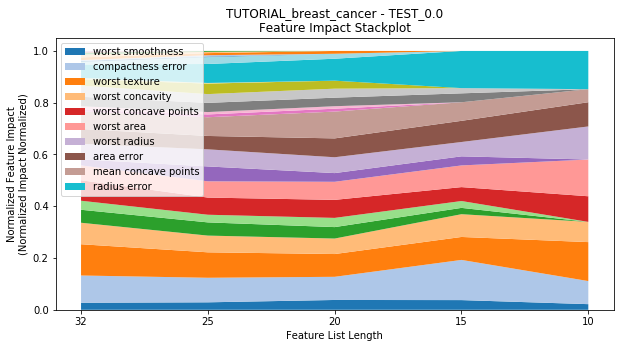

Performance Stackplot: 6.53s


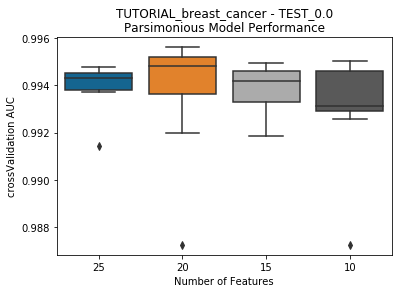

Model Performance Boxplot: 1.60s
Current model performance: '0.995618'. Previous best model performance: '0.995618'
No change in the best model, so a life was lost.
Lives remaining: '3'
Checking lives: 59.32s
Lives left: 3 | Previous Model Best Score: 0.994668 | Current Best Model Score: current_best_model_score=0.994762
Mean Error Limit: 3.27s
CV Error From the Mean: 0.009304612277078133 | CV Mean Error Limit: 0.8 | CV Model Performance Metric: AUC
---------- TEST_0.0 (5) ----------
Autopilot: 355.19s
Feature Impact job(s) remaining (0)
Feature Impact: 114.01s
Waiting for DataRobot: 5.89s


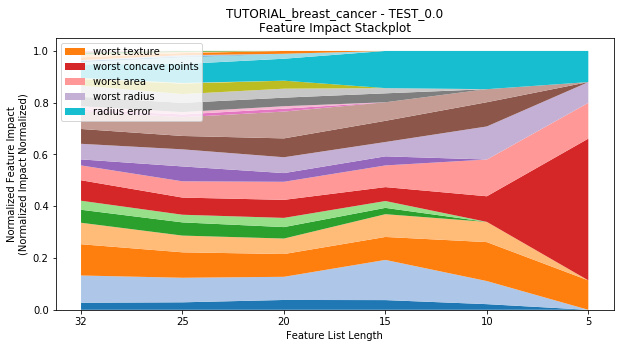

Performance Stackplot: 7.49s


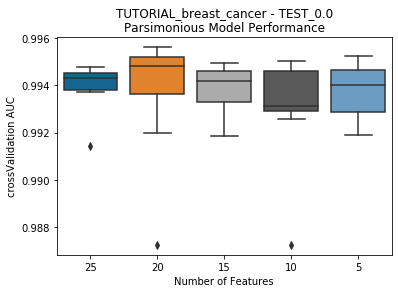

Model Performance Boxplot: 1.79s
Current model performance: '0.995618'. Previous best model performance: '0.995618'
No change in the best model, so a life was lost.
Lives remaining: '2'
Checking lives: 70.79s
Lives left: 2 | Previous Model Best Score: 0.994668 | Current Best Model Score: current_best_model_score=0.994762
Mean Error Limit: 3.38s
CV Error From the Mean: 0.00924233170372756 | CV Mean Error Limit: 0.8 | CV Model Performance Metric: AUC
---------- TEST_0.0 (4) ----------
Autopilot: 393.06s
Feature Impact job(s) remaining (0)
Feature Impact: 94.61s
Waiting for DataRobot: 5.99s


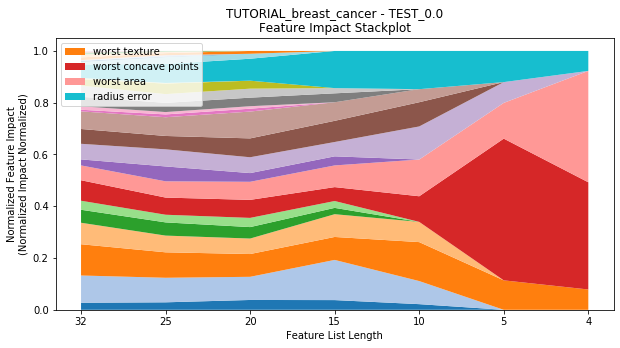

Performance Stackplot: 10.64s


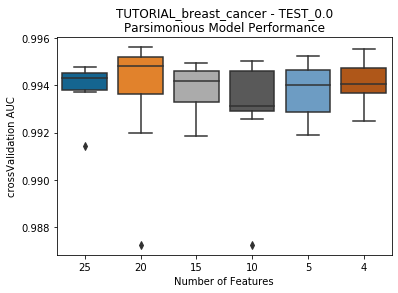

Model Performance Boxplot: 2.54s
Current model performance: '0.995618'. Previous best model performance: '0.995618'
No change in the best model, so a life was lost.
Lives remaining: '1'
Checking lives: 91.17s
Lives left: 1 | Previous Model Best Score: 0.994668 | Current Best Model Score: current_best_model_score=0.994762
Mean Error Limit: 3.17s
CV Error From the Mean: 0.008594882586850719 | CV Mean Error Limit: 0.8 | CV Model Performance Metric: AUC
---------- TEST_0.0 (3) ----------
Autopilot: 475.42s
Feature Impact job(s) remaining (0)
Feature Impact: 220.63s
Waiting for DataRobot: 6.01s


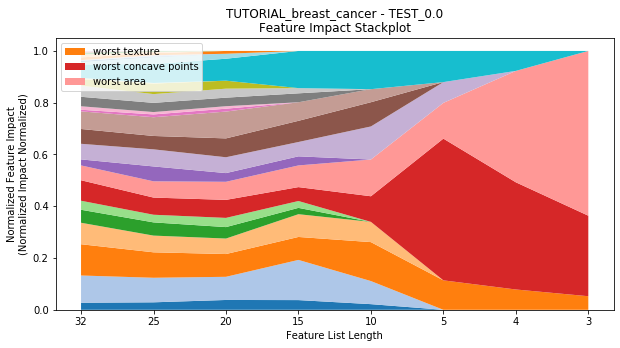

Performance Stackplot: 10.56s


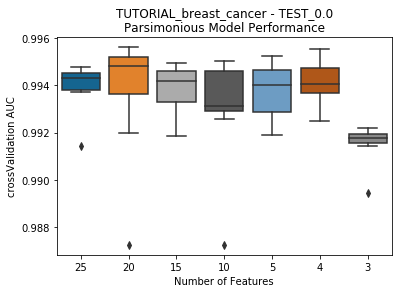

Model Performance Boxplot: 2.65s
Current model performance: '0.995618'. Previous best model performance: '0.995618'
No change in the best model, so a life was lost.
Lives remaining: '0'
Checking lives: 133.92s
Lives left: 0 | Previous Model Best Score: 0.994668 | Current Best Model Score: current_best_model_score=0.994762
Mean Error Limit: 3.07s
CV Error From the Mean: 0.01420246944461085 | CV Mean Error Limit: 0.8 | CV Model Performance Metric: AUC
---------- TEST_0.0 (2) ----------
Autopilot: 616.57s
Feature Impact job(s) remaining (0)
Feature Impact: 127.22s
Waiting for DataRobot: 5.90s


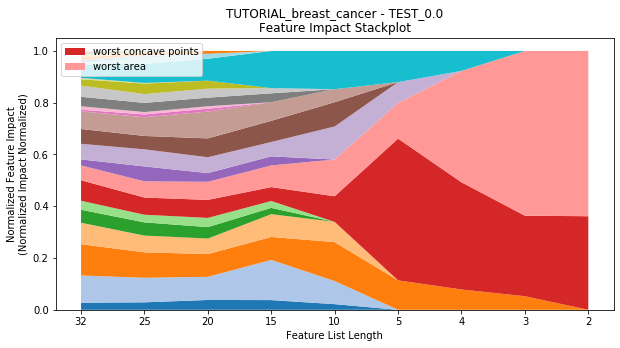

Performance Stackplot: 11.39s


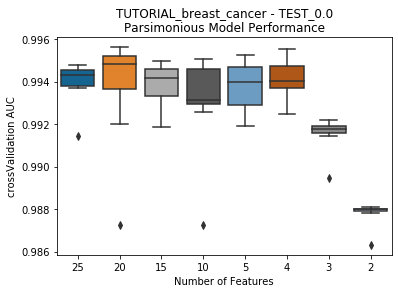

Model Performance Boxplot: 5.01s
Current model performance: '0.995618'. Previous best model performance: '0.995618'
No change in the best model, so a life was lost.
Lives remaining: '-1'
Checking lives: 131.52s
Ran out of lives.
Best model: 'Model('Nystroem Kernel SVM Classifier')'
Accuracy (AUC):'0.995618'
Finished Parsimony Analysis in 5814.74s.


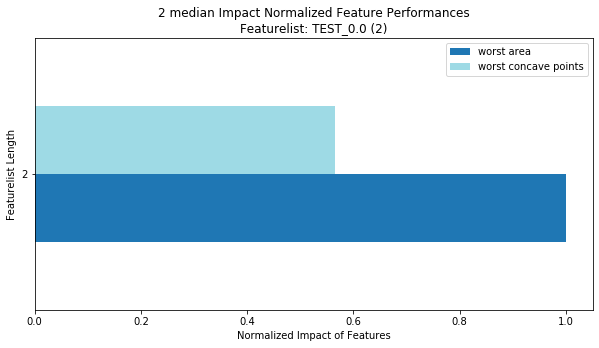

In [13]:
ret = depression_classification.perform_parsimony(project=project, 
                                            featurelist_prefix='TEST_0.0', 
                                            starting_featurelist_name='Informative Features', 
                                            feature_range=[25, 20, 15, 10, 5, 4, 3, 2, 1],
                                            lives=5,
                                            cv_average_mean_error_limit=.8,
                                            to_graph=['feature_performance', 'models'])